# Imports

In [1]:
from rdflib import Graph, Namespace, RDF, RDFS, Literal, URIRef
import uuid
import datetime
from datetime import timezone
from starvers.starvers import TripleStoreEngine
from scipy.io import arff
import pandas as pd

# new imports
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn as sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [2]:
#Ben
# executed_by ='stud-id_12038369'

#Philipp
executed_by ='stud-id_12132552'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

# Graph-based documentation preliminaries

Set your group and student IDs. Do this only once.

In [3]:
# group id for this project
group_id = '13'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12038369'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12132552'  #philipps MA Nummer

In [4]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [5]:
# Triple Store Endpoints
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

# old endpoints
# get_endpoint = "https://starvers.ec.tuwien.ac.at/SOS2025"
# post_endpoint = "https://starvers.ec.tuwien.ac.at/SOS2025/statements"

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook.

In [6]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/', # replace SOS2025 with BI2025 because otherwise did not work
}

In [7]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO.

In [8]:
# Ontologies used: foaf, prov, IAO

# Benicio Daniel
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Benicio" .',
f':{student_a} foaf:familyName "Daniel" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "12038369"^^xsd:string .',
]
# Philipp Schott
reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Philipp" .',
f':{student_b} foaf:familyName "Schott" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "12132552"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [9]:
ASSOC_RUN1_EXEC = '0ff89396-5f86-4497-9b5e-26e5aba9ca55'

In [10]:

#DATASET_UUID   = str(uuid.uuid4())
#DIST_UUID      = str(uuid.uuid4())
#RECORDSET_UUID = str(uuid.uuid4())

#print("DATASET_UUID =", DATASET_UUID)
#print("DIST_UUID =", DIST_UUID)
#print("RECORDSET_UUID =", RECORDSET_UUID)

In [11]:
# --- 2. Hard-code the UUIDs (example values — replace with yours) ---
DATASET_UUID = "d60ba562-ba83-4f5b-8951-6918e9e43539"
DIST_UUID = "51207666-9e42-4a62-82e2-cef6b56c70e8"
RECORDSET_UUID = "0ca825e0-8119-4803-bd95-d8e4f89ccb28"

DATASET_ID   = f"dataset-{DATASET_UUID}"
DIST_ID      = f"dist-{DIST_UUID}"
RECORDSET_ID = f"rs-{RECORDSET_UUID}"

dataset_description = """
The dataset contains person-level records from the Fatality Analysis Reporting System (FARS),
describing individuals involved in fatal traffic accidents in the United States.
It includes demographic, vehicle-related, and accident-related attributes.
The target variable class represents the injury severity outcome and is used for classification.
"""

dataset_triples = [
    f':{DATASET_ID} rdf:type sc:Dataset .',
    f':{DATASET_ID} sc:name "FARS Traffic Accident Person-Level Dataset"^^xsd:string .',
    f':{DATASET_ID} sc:description """{dataset_description}"""^^xsd:string .',

    f':{DATASET_ID} sc:license "https://opendatacommons.org/licenses/odbl/"^^xsd:anyURI .',
    f':{DATASET_ID} sc:url "https://www.openml.org/d/40672"^^xsd:anyURI .',
    f':{DATASET_ID} sc:keywords "traffic accidents, FARS, OpenML, SOM, classification"^^xsd:string .',

    # Distribution (where the data can be fetched)
    f':{DATASET_ID} sc:distribution :{DIST_ID} .',
    f':{DIST_ID} rdf:type sc:DataDownload .',
    f':{DIST_ID} sc:contentUrl "file://data/fars.arff"^^xsd:anyURI .',
    f':{DIST_ID} sc:encodingFormat "application/arff"^^xsd:string .',
]

croissant_description = """
Each record corresponds to one person involved in a fatal traffic accident.
Rows represent individual persons, columns represent attributes such as age, sex,
vehicle characteristics, accident conditions, and injury outcome.
"""

croissant_triples = [
    f':{DATASET_ID} cr:recordSet :{RECORDSET_ID} .',
    f':{RECORDSET_ID} rdf:type cr:RecordSet .',
    f':{RECORDSET_ID} cr:description """{croissant_description}"""^^xsd:string .',
    # Add fields (columns) similarly if you want (cr:Field), one per feature/label.
]

engine.insert(dataset_triples + croissant_triples, prefixes=prefixes)

# Business Understanding

In [12]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)

In [13]:
#############################################
# Documentation
#############################################

BU_ASSOC = "bu_assoc_01"

bu_comment = """
This project analyzes the given dataset to better understand its structure, quality, and suitability for subsequent modeling steps as part of the SOS assignment.
"""

business_understanding_activity = [
    ':business_understanding rdf:type prov:Activity .',
    ':business_understanding sc:isPartOf :business_understanding_phase .',
    ':business_understanding rdfs:label "Business Understanding" .',
    f':business_understanding rdfs:comment """{bu_comment}""" .',

    f':business_understanding prov:qualifiedAssociation :{BU_ASSOC} .',
    f':{BU_ASSOC} rdf:type prov:Association .',
    f':{BU_ASSOC} prov:agent :{executed_by} .',
    f':{BU_ASSOC} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_activity, prefixes=prefixes)

# Data Understanding

In [14]:
## Each Activity that follows is part of the Data Understanding Phase

data_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', ## Phase 2: Data Understanding
]
engine.insert(data_understanding_phase_executor, prefixes=prefixes)

In [15]:
load_fars_data_writer = student_b  # Philipp Schott

def load_fars_data() -> pd.DataFrame:
    """Load FARS data and return as DataFrame."""

    # Load ARFF file and convert to DataFrame
    arff_file = arff.loadarff('../data/fars.arff')
    df_fars = pd.DataFrame(arff_file[0])
    df_fars_meta = pd.DataFrame(arff_file[1])
    return df_fars, df_fars_meta

# Execution of the data loading activity
start_time_load_fars = now()
df_fars, df_fars_meta = load_fars_data()
end_time_load_fars = now()

display(df_fars.head())
display(df_fars_meta)
display(df_fars.dtypes)
display(df_fars.shape)
display(df_fars.nunique())

#############################################
# Documentation
#############################################
DU_ASSOC_LOAD_FARS = "du_assoc_load_fars_01"
DU_ASSOC_LOAD_FARS_EX = "du_assoc_load_fars_exec_01"

du_comment_load_fars = """
The dataset is provided in ARFF format and consists of approximately 100,000 person-level traffic accident records with 30 variables. 
It contains a mixture of numerical attributes and a large number of categorical variables encoded as byte or object values. 
The variable 'class' represents the target outcome. 
Initial inspection indicates that decoding and categorical encoding will be required in the Data Preparation phase. 
No data transformations were applied at this stage.
"""

data_understanding_load_fars_activity = [
    ':data_understanding_load_fars rdf:type prov:Activity .',
    ':data_understanding_load_fars sc:isPartOf :data_understanding_phase .',
    ':data_understanding_load_fars rdfs:label "Load FARS Data" .',
    f':data_understanding_load_fars rdfs:comment """{du_comment_load_fars}""" .',
    f':data_understanding_load_fars prov:startedAtTime "{start_time_load_fars}"^^xsd:dateTime .',
    f':data_understanding_load_fars prov:endedAtTime "{end_time_load_fars}"^^xsd:dateTime .',

    f':data_understanding_load_fars prov:qualifiedAssociation :{DU_ASSOC_LOAD_FARS} .',
    f':{DU_ASSOC_LOAD_FARS} rdf:type prov:Association .',
    f':{DU_ASSOC_LOAD_FARS} prov:agent :{load_fars_data_writer} .',
    f':{DU_ASSOC_LOAD_FARS} prov:hadRole :{code_executor_role} .',

    f':data_understanding_load_fars prov:qualifiedAssociation :{DU_ASSOC_LOAD_FARS_EX} .',
    f':{DU_ASSOC_LOAD_FARS_EX} rdf:type prov:Association .',
    f':{DU_ASSOC_LOAD_FARS_EX} prov:agent :{executed_by} .',
    f':{DU_ASSOC_LOAD_FARS_EX} prov:hadRole :{code_executor_role} .',
]
engine.insert(data_understanding_load_fars_activity, prefixes=prefixes)

,CASE_STATE,AGE,SEX,PERSON_TYPE,SEATING_POSITION,RESTRAINT_SYSTEM-USE,AIR_BAG_AVAILABILITY/DEPLOYMENT,EJECTION,EJECTION_PATH,EXTRICATION,...,DRUG_TEST_RESULTS_(2_of_3),DRUG_TEST_TYPE_(3_of_3),DRUG_TEST_RESULTS_(3_of_3),HISPANIC_ORIGIN,TAKEN_TO_HOSPITAL,RELATED_FACTOR_(1)-PERSON_LEVEL,RELATED_FACTOR_(2)-PERSON_LEVEL,RELATED_FACTOR_(3)-PERSON_LEVEL,RACE,class
0,0.0,34.0,b'1',b'1',3.0,7.0,2.0,b'2',b'9',b'1',...,0.0,b'2',0.0,b'5',b'0',27.0,29.0,19.0,17.0,b'1'
1,0.0,20.0,b'1',b'1',3.0,7.0,9.0,b'2',b'9',b'1',...,0.0,b'2',0.0,b'5',b'0',27.0,29.0,19.0,17.0,b'1'
2,0.0,43.0,b'1',b'1',3.0,5.0,4.0,b'0',b'0',b'0',...,0.0,b'2',0.0,b'5',b'0',27.0,29.0,19.0,4.0,b'1'
3,0.0,38.0,b'0',b'6',6.0,5.0,4.0,b'0',b'0',b'0',...,0.0,b'2',0.0,b'6',b'2',27.0,29.0,19.0,11.0,b'2'
4,0.0,50.0,b'1',b'1',3.0,5.0,9.0,b'0',b'0',b'1',...,0.0,b'2',0.0,b'5',b'2',27.0,29.0,19.0,4.0,b'1'


,0
0,CASE_STATE
1,AGE
2,SEX
3,PERSON_TYPE
4,SEATING_POSITION
5,RESTRAINT_SYSTEM-USE
6,AIR_BAG_AVAILABILITY/DEPLOYMENT
7,EJECTION
8,EJECTION_PATH
9,EXTRICATION


CASE_STATE                             float64
AGE                                    float64
SEX                                     object
PERSON_TYPE                             object
SEATING_POSITION                       float64
RESTRAINT_SYSTEM-USE                   float64
AIR_BAG_AVAILABILITY/DEPLOYMENT        float64
EJECTION                                object
EJECTION_PATH                           object
EXTRICATION                             object
NON_MOTORIST_LOCATION                  float64
POLICE_REPORTED_ALCOHOL_INVOLVEMENT     object
METHOD_ALCOHOL_DETERMINATION            object
ALCOHOL_TEST_TYPE                       object
ALCOHOL_TEST_RESULT                    float64
POLICE-REPORTED_DRUG_INVOLVEMENT        object
METHOD_OF_DRUG_DETERMINATION            object
DRUG_TEST_TYPE                          object
DRUG_TEST_RESULTS_(1_of_3)             float64
DRUG_TEST_TYPE_(2_of_3)                 object
DRUG_TEST_RESULTS_(2_of_3)             float64
DRUG_TEST_TYP

(100968, 30)

CASE_STATE                             51
AGE                                    99
SEX                                     3
PERSON_TYPE                            10
SEATING_POSITION                       26
RESTRAINT_SYSTEM-USE                   12
AIR_BAG_AVAILABILITY/DEPLOYMENT        13
EJECTION                                4
EJECTION_PATH                          10
EXTRICATION                             3
NON_MOTORIST_LOCATION                  18
POLICE_REPORTED_ALCOHOL_INVOLVEMENT     4
METHOD_ALCOHOL_DETERMINATION            7
ALCOHOL_TEST_TYPE                      10
ALCOHOL_TEST_RESULT                    69
POLICE-REPORTED_DRUG_INVOLVEMENT        4
METHOD_OF_DRUG_DETERMINATION            5
DRUG_TEST_TYPE                          7
DRUG_TEST_RESULTS_(1_of_3)             95
DRUG_TEST_TYPE_(2_of_3)                 7
DRUG_TEST_RESULTS_(2_of_3)             73
DRUG_TEST_TYPE_(3_of_3)                 7
DRUG_TEST_RESULTS_(3_of_3)             59
HISPANIC_ORIGIN                   

The output shows that the dataset requirements are met and the data is loaded successfully.

# Data Preprocessing

In [16]:
## Each Activity that follows is part of the Data Preprocessing Phase

data_preprocessing_phase_executor = [
f':data_preprocessing_phase rdf:type prov:Activity .',
f':data_preprocessing_phase rdfs:label "Data Preprocessing Phase" .', ## Phase 3: Data Preprocessing
]
engine.insert(data_preprocessing_phase_executor, prefixes=prefixes)

In [17]:
load_fars_data_writer = student_b  # Philipp Schott

# Data Preprocessing
## Step 1: Decode byte-encoded categorical attributes
def bytes_object_to_category(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert byte-encoded / object-type categorical columns to pandas 'category' dtype.
    - Decodes byte strings to UTF-8
    - Converts resulting columns to 'category'
    - Leaves numeric columns untouched
    """
    df_out = df.copy()

    for col in df_out.columns:
        if df_out[col].dtype == object:
            df_out[col] = df_out[col].apply(
                lambda x: x.decode("utf-8") if isinstance(x, bytes) else x
            )
            df_out[col] = df_out[col].astype("category")

    return df_out

# Execute preprocessing step
start_time_decode = now()
df_fars_decoded = bytes_object_to_category(df_fars)
end_time_decode = now()

preprep_comment_decode = """
Now since I understand the data after decoding the byte-encoded categorical variables, I can see that the dataset is ready for further analysis and modeling.
In the next steps, I will explore the data distributions, check for missing values, and prepare the data for modeling.
"""

DP_ASSOC_DECODE_WRITER = "dp_assoc_decode_writer"
DP_ASSOC_DECODE_EXEC   = "dp_assoc_decode_exec"

data_preparation_decode_activity = [
    ':data_preparation_decode rdf:type prov:Activity .',
    ':data_preparation_decode sc:isPartOf :data_preprocessing_phase .',
    ':data_preparation_decode rdfs:label "Decode Categorical Attributes" .',
    f':data_preparation_decode rdfs:comment """{preprep_comment_decode}""" .',
    f':data_preparation_decode prov:startedAtTime "{start_time_decode}"^^xsd:dateTime .',
    f':data_preparation_decode prov:endedAtTime "{end_time_decode}"^^xsd:dateTime .',

    # Writer
    f':data_preparation_decode prov:qualifiedAssociation :{DP_ASSOC_DECODE_WRITER} .',
    f':{DP_ASSOC_DECODE_WRITER} rdf:type prov:Association .',
    f':{DP_ASSOC_DECODE_WRITER} prov:agent :{load_fars_data_writer} .',
    f':{DP_ASSOC_DECODE_WRITER} prov:hadRole :{code_writer_role} .',

    # Executor
    f':data_preparation_decode prov:qualifiedAssociation :{DP_ASSOC_DECODE_EXEC} .',
    f':{DP_ASSOC_DECODE_EXEC} rdf:type prov:Association .',
    f':{DP_ASSOC_DECODE_EXEC} prov:agent :{executed_by} .',
    f':{DP_ASSOC_DECODE_EXEC} prov:hadRole :{code_executor_role} .',
]


display(df_fars_decoded.head())
display(df_fars_decoded.dtypes)

,CASE_STATE,AGE,SEX,PERSON_TYPE,SEATING_POSITION,RESTRAINT_SYSTEM-USE,AIR_BAG_AVAILABILITY/DEPLOYMENT,EJECTION,EJECTION_PATH,EXTRICATION,...,DRUG_TEST_RESULTS_(2_of_3),DRUG_TEST_TYPE_(3_of_3),DRUG_TEST_RESULTS_(3_of_3),HISPANIC_ORIGIN,TAKEN_TO_HOSPITAL,RELATED_FACTOR_(1)-PERSON_LEVEL,RELATED_FACTOR_(2)-PERSON_LEVEL,RELATED_FACTOR_(3)-PERSON_LEVEL,RACE,class
0,0.0,34.0,1,1,3.0,7.0,2.0,2,9,1,...,0.0,2,0.0,5,0,27.0,29.0,19.0,17.0,1
1,0.0,20.0,1,1,3.0,7.0,9.0,2,9,1,...,0.0,2,0.0,5,0,27.0,29.0,19.0,17.0,1
2,0.0,43.0,1,1,3.0,5.0,4.0,0,0,0,...,0.0,2,0.0,5,0,27.0,29.0,19.0,4.0,1
3,0.0,38.0,0,6,6.0,5.0,4.0,0,0,0,...,0.0,2,0.0,6,2,27.0,29.0,19.0,11.0,2
4,0.0,50.0,1,1,3.0,5.0,9.0,0,0,1,...,0.0,2,0.0,5,2,27.0,29.0,19.0,4.0,1


CASE_STATE                              float64
AGE                                     float64
SEX                                    category
PERSON_TYPE                            category
SEATING_POSITION                        float64
RESTRAINT_SYSTEM-USE                    float64
AIR_BAG_AVAILABILITY/DEPLOYMENT         float64
EJECTION                               category
EJECTION_PATH                          category
EXTRICATION                            category
NON_MOTORIST_LOCATION                   float64
POLICE_REPORTED_ALCOHOL_INVOLVEMENT    category
METHOD_ALCOHOL_DETERMINATION           category
ALCOHOL_TEST_TYPE                      category
ALCOHOL_TEST_RESULT                     float64
POLICE-REPORTED_DRUG_INVOLVEMENT       category
METHOD_OF_DRUG_DETERMINATION           category
DRUG_TEST_TYPE                         category
DRUG_TEST_RESULTS_(1_of_3)              float64
DRUG_TEST_TYPE_(2_of_3)                category
DRUG_TEST_RESULTS_(2_of_3)              

In [ ]:
prep_som_code_writer = student_b # Philipp Schott

# Step 2: Further preprocessing steps
# E.g., handling missing values, normalization, etc.

def rank_scale(series: pd.Series) -> pd.Series:
    """
    Rank-based scaling to [0,1].
    Preserves order but not absolute distances.
    """
    ranks = series.rank(method="average")
    return (ranks - 1) / (ranks.max() - 1)

def reduce_categories(series: pd.Series, min_freq=0.01) -> pd.Series:
    """
    Reduce categories with lower frequency than min_freq.
    """
    freq = series.value_counts(normalize=True)
    keep = freq[freq >= min_freq].index
    return series.where(series.isin(keep), other="OTHER")


def prepare_for_som(df: pd.DataFrame, target_col: str, numeric_cols: list, ordinal_cols: list, categorical_cols: list, min_freq: float = 0.01) -> pd.DataFrame:
    """
    Prepare dataframe for SOM:
    - Numeric: Z-score
    - Ordinal: Rank scaling
    - Categorical: Category reduction by min_freq + One-Hot Encoding
    """

    df_out = df.copy()

    # separate target
    y = df_out[target_col] if target_col in df_out else None
    X = df_out.drop(columns=[target_col], errors="ignore")

    # ---- Numeric: Z-score ----
    scaler_num = StandardScaler()
    X[numeric_cols] = scaler_num.fit_transform(X[numeric_cols])

    # ---- Ordinal: Rank scaling ----
    for col in ordinal_cols:
        X[col] = rank_scale(X[col])

    # ---- Categorical: reduce categories ----
    for col in categorical_cols:
        X[col] = X[col].astype("object")
        X[col] = reduce_categories(X[col], min_freq=min_freq)
        X[col] = X[col].astype("category")

    # ---- One-Hot Encoding ----
    X = pd.get_dummies(
        X,
        columns=categorical_cols,
        dummy_na=False,
        drop_first=False
    )

    # reattach target
    if y is not None:
        X[target_col] = y.values

    return X, scaler_num, "rank_scale", "one_hot_encoder"

# recoding dtypes of columns so they make more sense
numeric_cols = [
    "AGE",                           # True continuous variable; differences and ratios are meaningful
    "ALCOHOL_TEST_RESULT",           # Measured alcohol concentration; metric distance is meaningful
    "DRUG_TEST_RESULTS_(1_of_3)",    # Quantitative test result; higher/lower values indicate intensity
    "DRUG_TEST_RESULTS_(2_of_3)",    # Same as above; treated as weakly continuous
    "DRUG_TEST_RESULTS_(3_of_3)"     # Same as above; treated as weakly continuous
]

# some may be querable as ordinal but it reduces dimensionality
ordinal_cols = [
    "SEATING_POSITION",              # Ordered seating locations; order matters, distances do not
    "RESTRAINT_SYSTEM-USE",          # Increasing level of restraint usage; ordinal severity
    "AIR_BAG_AVAILABILITY/DEPLOYMENT",  # Ordered states from unavailable to deployed
    "EJECTION",                      # Ordered outcome (none → partial → full ejection)
    "EXTRICATION",                   # Increasing rescue complexity; ordinal severity
    "POLICE_REPORTED_ALCOHOL_INVOLVEMENT",  # Ordered certainty (no → yes → unknown)
    "POLICE-REPORTED_DRUG_INVOLVEMENT",     # Same logic as alcohol involvement
    "TAKEN_TO_HOSPITAL"              # Binary but ordered by injury severity (no → yes)
]

categorical_cols = [
    "CASE_STATE",                    # Geographic identifier; numeric codes have no metric meaning
    "SEX",                           # Nominal demographic category; no inherent order
    "PERSON_TYPE",                   # Role-based category (driver, passenger, pedestrian)
    "EJECTION_PATH",                 # Type of ejection; categories are unordered
    "NON_MOTORIST_LOCATION",         # Location categories; no ordinal relationship
    "METHOD_ALCOHOL_DETERMINATION",  # Measurement method; method types are unordered
    "ALCOHOL_TEST_TYPE",             # Type of alcohol test; nominal categories
    "METHOD_OF_DRUG_DETERMINATION",  # Drug detection method; no ordering
    "DRUG_TEST_TYPE",                # Tested substance type; unordered categories
    "DRUG_TEST_TYPE_(2_of_3)",       # Same as above; additional test slot
    "DRUG_TEST_TYPE_(3_of_3)",       # Same as above; additional test slot
    "HISPANIC_ORIGIN",               # Demographic category; nominal, not ordinal
    "RELATED_FACTOR_(1)-PERSON_LEVEL",  # Contributing factor codes; labels without metric meaning
    "RELATED_FACTOR_(2)-PERSON_LEVEL",  # Same as above; unordered causal codes
    "RELATED_FACTOR_(3)-PERSON_LEVEL",  # Same as above; unordered causal codes
    "RACE"                           # Demographic category; nominal with no inherent order
]

# Execute preprocessing for SOM
start_som_prep = now()

# frequency threshold 1% to reduce sparsity in feature space
min_freq_1 = 0.01

df_fars_scaled_1per100, scaler_num, scaler_ord, scaler_cat = prepare_for_som(
    df_fars_decoded,
    target_col="class",
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_cols,
    categorical_cols=categorical_cols,
    min_freq=min_freq_1
)

# frequency threshold 0.1% to reduce sparsity in feature space
min_freq_2 = 0.001

df_fars_scaled_1per1000, scaler_num, scaler_ord, scaler_cat = prepare_for_som(
    df_fars_decoded,
    target_col="class",
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_cols,
    categorical_cols=categorical_cols,
    min_freq=min_freq_2
)
end__som_prep = now()

preprep_comment_som = f"""
The dataset has been preprocessed for Self-Organizing Map (SOM) training.
All features are convertet to the appropriate data types after manually checking there interpretation.

Numeric features have been standardized using {scaler_num},
ordinal features have been standardized using {scaler_ord},
while categorical features have been encoded using {scaler_cat}.
The target variable 'class' remains unchanged.
This was done to make the data more suitable for SOM training, especially since SOMs are sensitive to the scale of input features.

Earlier, just a division into numeric and categorical features was used which resulted in 350+ features with {scaler_num}, which we felt was not suitable for SOMs.
Therefore we introduced ordinal scale features to scale then using {scaler_ord} to simulatiously preserve order but reduce dimensionality.
We also used Minimum-frequency category reduction which aggregates infrequent nominal categories into a shared "OTHER§ class, 
reducing sparsity and noise while preserving the dominant categorical structure relevant for distance-based learning methods.

This was done to make the data more suitable for SOM training, especially since SOMs are sensitive to the scale of input features.
To summarize, the data is now ready for SOM training and further analysis.

The resulting dataset using {min_freq_1} as a frequency threshold has the shape {df_fars_scaled_1per100.shape} and contains no missing values.
The resulting dataset using {min_freq_2} as a frequency threshold has the shape {df_fars_scaled_1per1000.shape} and contains no missing values.
"""

DP_ASSOC_SCALE_WRITER = "dp_assoc_scale_writer"
DP_ASSOC_SCALE_EXEC   = "dp_assoc_scale_exec"
SCALED_DATASET_ID     = "dataset-fars-scaled"

data_preparation_scaling_activity = [
    ':data_preparation_scaling rdf:type prov:Activity .',
    ':data_preparation_scaling sc:isPartOf :data_preprocessing_phase .',
    ':data_preparation_scaling rdfs:label "Feature Encoding and Scaling for SOM" .',
    f':data_preparation_scaling rdfs:comment """{preprep_comment_som}""" .',
    f':data_preparation_scaling prov:startedAtTime "{start_som_prep}"^^xsd:dateTime .',
    f':data_preparation_scaling prov:endedAtTime "{end__som_prep}"^^xsd:dateTime .',

    # Writer
    f':data_preparation_scaling prov:qualifiedAssociation :{DP_ASSOC_SCALE_WRITER} .',
    f':{DP_ASSOC_SCALE_WRITER} rdf:type prov:Association .',
    f':{DP_ASSOC_SCALE_WRITER} prov:agent :{prep_som_code_writer} .',
    f':{DP_ASSOC_SCALE_WRITER} prov:hadRole :{code_writer_role} .',

    # Executor
    f':data_preparation_scaling prov:qualifiedAssociation :{DP_ASSOC_SCALE_EXEC} .',
    f':{DP_ASSOC_SCALE_EXEC} rdf:type prov:Association .',
    f':{DP_ASSOC_SCALE_EXEC} prov:agent :{executed_by} .',
    f':{DP_ASSOC_SCALE_EXEC} prov:hadRole :{code_executor_role} .',
]

scaled_dataset_triples = [
    f':{SCALED_DATASET_ID} rdf:type sc:Dataset .',
    f':{SCALED_DATASET_ID} sc:name "FARS Dataset - Encoded and Scaled for SOM"^^xsd:string .',
    f':{SCALED_DATASET_ID} sc:isBasedOn :dataset-{DATASET_UUID} .',
]

croissant_scaling_fields = [
    f':{RECORDSET_ID} cr:field :numeric_features .',
    f':numeric_features rdf:type cr:Field .',
    f':numeric_features cr:name "Numeric Features"^^xsd:string .',
    f':numeric_features cr:description "Numerical attributes standardized using {scaler_num}."^^xsd:string .',

    f':{RECORDSET_ID} cr:field :ordinal_features .',
    f':ordinal_features rdf:type cr:Field .',
    f':ordinal_features cr:name "Ordinal Features"^^xsd:string .',
    f':ordinal_features cr:description "Ordinal attributes standardized using {scaler_ord}."^^xsd:string .',

    f':{RECORDSET_ID} cr:field :categorical_features .',
    f':categorical_features rdf:type cr:Field .',
    f':categorical_features cr:name "Categorical Features"^^xsd:string .',
    f':categorical_features cr:description "Categorical attributes encoded using {scaler_cat}."^^xsd:string .',
]

engine.insert(data_preparation_scaling_activity + scaled_dataset_triples + croissant_scaling_fields, prefixes=prefixes)

In [ ]:
# Safe the scaled dataset as a gzip file for later use
#df_fars_scaled_1per100.to_csv("../data/fars_scaled_1per100.csv.gz", index=False, compression="gzip")
#df_fars_scaled_1per1000.to_csv("../data/fars_scaled_1per1000.csv.gz", index=False, compression="gzip")

## Exploratory Data Analysis Phase

In this phase, we'll explore the dataset to gain insights into its structure and characteristics.

This function was used during the process of understanding the dataset.

In [ ]:
def describe_dataset_v2(df: pd.DataFrame, name: str = "Dataset", top_n_missing: int = 10) -> None:
    """
    Describes the dataset, including shape, missing values, top columns with missing values, and correlation heatmap.
    """
    print(f"\n===== {name} =====\n")

    # ---- Shape ----
    n_rows, n_cols = df.shape
    print("=== Dataset shape ===")
    print(f"Rows: {n_rows:,}")
    print(f"Columns: {n_cols}")
    print()

    # ---- Missing values (dataset-level) ----
    total_cells = n_rows * n_cols
    total_missing = df.isna().sum().sum()
    pct_missing = 100 * total_missing / total_cells

    cols_with_missing = (df.isna().sum() > 0).sum()

    print("=== Missing values (dataset-level) ===")
    print(f"Total missing values: {total_missing:,}")
    print(f"Missing percentage (overall): {pct_missing:.4f}%")
    print(f"Columns with missing values: {cols_with_missing} / {n_cols}")
    print()

    # ---- Top columns with missing values ----
    if total_missing > 0:
        print(f"=== Top {top_n_missing} columns by missing percentage ===")
        missing_by_col = (
            df.isna().mean()
            .mul(100)
            .sort_values(ascending=False)
            .head(top_n_missing)
        )
        print(missing_by_col)
        print()

    # ---- Duplicates ----
    dup_count = df.duplicated().sum()

    print("=== Duplicate rows ===")
    print(f"Duplicate rows: {dup_count:,}")
    print()

    # ---- Feature type summary ----
    print("=== Feature types ===")
    print(df.dtypes.value_counts())
    print()

    # ---- Sparsity (important for One-Hot / SOM) ----
    zero_frac = (df == 0).sum().sum() / total_cells
    print("=== Sparsity ===")
    print(f"Fraction of zero entries: {zero_frac:.4f}")
    print()

    # ---- Memory usage ----
    mem_mb = df.memory_usage(deep=True).sum() / 1024**2
    print("=== Memory usage ===")
    print(f"Total memory usage: {mem_mb:.2f} MB")
    print()

    # ---- Numeric correlation summary ----
    numeric_df = df.select_dtypes(include=np.number)
    if numeric_df.shape[1] > 1:
        plt.figure(figsize=(6, 4))
        sns.heatmap(numeric_df.corr(), cmap="Blues")
        plt.title("Correlation Heatmap")
        plt.show()


===== FARS Scaled Dataset (1%) =====

=== Dataset shape ===
Rows: 100,968
Columns: 109

=== Missing values (dataset-level) ===
Total missing values: 0
Missing percentage (overall): 0.0000%
Columns with missing values: 0 / 109

=== Duplicate rows ===
Duplicate rows: 8,079

=== Feature types ===
bool        95
float64     13
category     1
Name: count, dtype: int64

=== Sparsity ===
Fraction of zero entries: 0.7248

=== Memory usage ===
Total memory usage: 19.26 MB



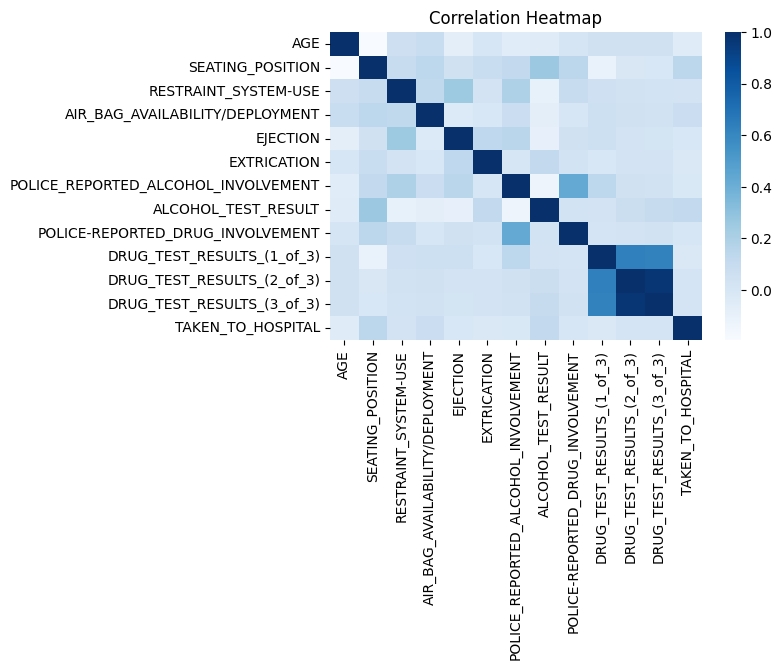

In [59]:
describe_dataset_v2(df_fars_scaled_1per100, name="FARS Scaled Dataset (1%)")


===== FARS Scaled Dataset (0.1%) =====

=== Dataset shape ===
Rows: 100,968
Columns: 169

=== Missing values (dataset-level) ===
Total missing values: 0
Missing percentage (overall): 0.0000%
Columns with missing values: 0 / 169

=== Duplicate rows ===
Duplicate rows: 7,964

=== Feature types ===
bool        155
float64      13
category      1
Name: count, dtype: int64

=== Sparsity ===
Fraction of zero entries: 0.8225

=== Memory usage ===
Total memory usage: 25.04 MB



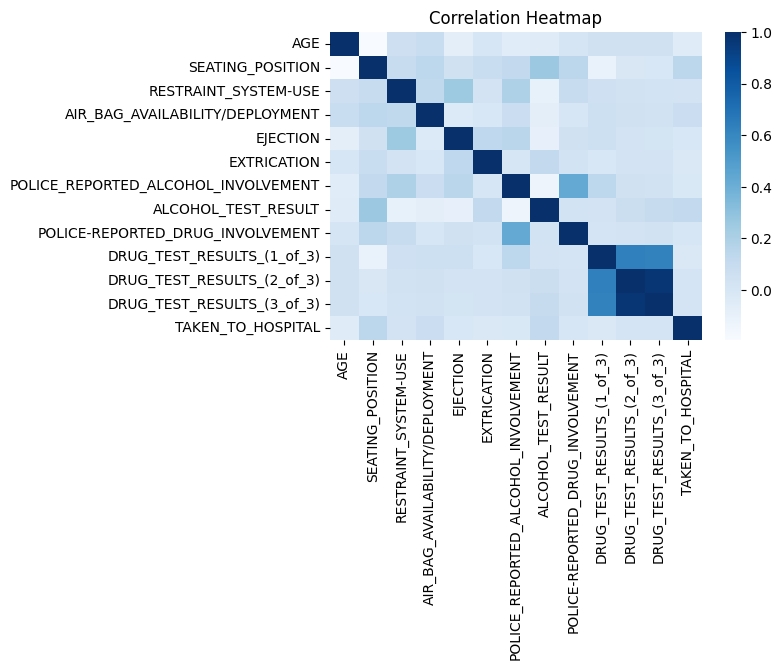

In [60]:
describe_dataset_v2(df_fars_scaled_1per1000, name="FARS Scaled Dataset (0.1%)") 

# SOM Training

In [ ]:
## Each Activity that follows is part of the SOM Training Phase

SOM_training_phase_executor = [
f':SOM_training_phase rdf:type prov:Activity .',
f':SOM_training_phase rdfs:label "SOM Training Phase" .', ## Phase 4: SOM Training
]
engine.insert(SOM_training_phase_executor, prefixes=prefixes)


===== FARS Scaled Dataset =====


==== Data set shape ===
(100968, 109)

=== MISSING VALUES (count | %) ===
                     missing_count  missing_percent    dtype
AGE                              0              0.0  float64
ALCOHOL_TEST_TYPE_9              0              0.0     bool
DRUG_TEST_TYPE_6                 0              0.0     bool
DRUG_TEST_TYPE_5                 0              0.0     bool
DRUG_TEST_TYPE_4                 0              0.0     bool
...                            ...              ...      ...
CASE_STATE_31.0                  0              0.0     bool
CASE_STATE_30.0                  0              0.0     bool
CASE_STATE_25.0                  0              0.0     bool
CASE_STATE_24.0                  0              0.0     bool
class                            0              0.0    int64

[109 rows x 3 columns]


Duplicated rows: 8079


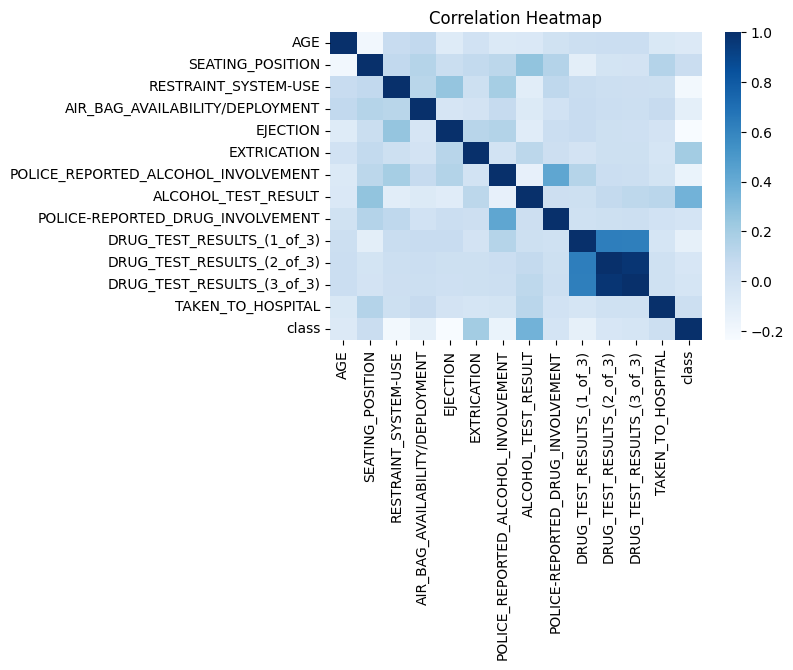

In [50]:
# Load scaled dataset directly from gzip-compressed CSV
input_path = "../data/fars_scaled_1per100.csv.gz"

df_fars_scaled = pd.read_csv(
    input_path,
    compression="gzip"
)

# Final prepared data for modeling
df_fars_scaled.columns = df_fars_scaled.columns.str.strip()
y, X = df_fars_scaled["class"], df_fars_scaled.drop(columns=["class"]) 
# maybe think about categorical features being one-hot encoded resulting in many more columns (feature space engenering)

describe_dataset(df_fars_scaled, name="FARS Scaled Dataset")

# Evaluation and Interpretation